## Data

We need to download the twitter data from this site: http://alt.qcri.org/semeval2017/task4/
link : [Link](https://www.dropbox.com/s/byzr8yoda6bua1b/2017_English_final.zip?file_subpath=%2F2017_English_final%2FGOLD%2FSubtask_A) and copy it to the PATH location.

The notebook use fastai.text module which in many cases is faster than torchtext. Fastai is an awesome library build on to of pytorch and contain many useful tools

In [1]:
from fastai.text import *
import html
from pathlib import Path

In [2]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path('data/twitter/sentiment_train')

## Standardize format

In [3]:
CLAS_PATH=Path('data/twitter/clas') #path for data for classification model
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('data/twitter/lm') #path for data for language model
LM_PATH.mkdir(exist_ok=True)

The semval dataset has 3 classes. positive, negative and neutral. 
All data from previous years will be used for training. 
Test set from 2016 will be used as dev/test set.


In [4]:
CLASSES = ['negative', 'neutral', 'positive']
class_toint = {'negative':0, 'neutral':1, 'positive':2}
class_totxt = {0:'negative', 1:'neutral', 2:'positive'}

In [5]:
import pandas as pd
#get data to one array
def get_data(path):
    texts,labels,dss = [],[],[]
    for fname in (path).glob('*.t*'):
        tmp_txt = pd.read_csv(fname, sep='\t', header=None).dropna(1)
        tmp_txt['ds'] = str(fname).split('/')[-1]
        dss.append(tmp_txt.iloc[:,-1].values)
        texts.append(tmp_txt.iloc[:,-2].values)
        labels.append(tmp_txt.iloc[:,-3].values)
    return np.concatenate(texts),np.concatenate(labels),np.concatenate(dss)


all_texts, all_labels_txt, all_dss = get_data(PATH)


In [6]:
#check for wrong labels
np.unique(all_labels_txt)

array(['negative', 'neutral', 'positive'], dtype=object)

In [7]:
#change text labels to numbers
all_labels = np.array([class_toint[i] for i in all_labels_txt])

In [8]:
#check if imported arrays looks good
all_labels.shape, all_texts.shape, all_dss.shape

((53368,), (53368,), (53368,))

In [9]:
col_names = ['labels','text']

In [10]:
all_data_df = pd.DataFrame({'text':all_texts, 'labels':all_labels, 'dataset':all_dss}, columns=col_names + ['dataset'])
#remove duplicates
print('duplicates:', np.sum(all_data_df.duplicated(subset=col_names[1])))
all_data_df = all_data_df.drop_duplicates(subset=col_names[1])
print('duplicates:', np.sum(all_data_df.duplicated(subset=col_names[1])))

duplicates: 778
duplicates: 0


In [11]:
#twits should be rather short, lets check if there are any twits longer than 280 characters
all_data_df[all_data_df['text'].map(len)>280]

,labels,text,dataset
9703,2,Nice to know my friends care and are genuinely...,twitter-2014sarcasm-A.txt
12797,2,Batman may of been the better man in our last ...,twitter-2016train-A.txt
13611,2,@106andpark: Did you enjoy last night's Life O...,twitter-2016train-A.txt
13867,1,All presidents of American except one are or h...,twitter-2016train-A.txt
15069,1,"Take the Romans. In the 2nd-3rd centuries BC, ...",twitter-2016train-A.txt
15425,2,In 2015 Forbes ranked Nestle as the 30th large...,twitter-2016train-A.txt
43830,2,hey andy sori real late in writing tis. So how...,sms-2013test-A.tsv
44357,2,Hi\u002c this is Nigel. I\u2019ll like to wish...,sms-2013test-A.tsv
44400,1,If u sad should say mah\u002c then i will go. ...,sms-2013test-A.tsv
47357,2,@SportsCenter: Serena remains on top! The youn...,twitter-2016dev-A.txt


In [12]:
all_data_df['text'].loc[12797]

'Batman may of been the better man in our last encounter,   but I\'m a man on a mission and it\'s to expose you for what you really are and --\n640710805508497415\tpositive\tHeath Ledger in Batman may be the best performance of any actor in any movie of all time\n640711961252990976\tneutral\t@040hz I mean, Batman was corny af until this trilogy, the 3rd one was so not Batman.\n640766902772502528\tneutral\t@headgeek666 TOM HARDY should play BANE again... He should kill BATMAN when they want 2 replace like in the comics... The 3rd... KNIGHTFALL\n640820660214730752\tnegative\tWhatever, Batman. You may call it the Batcave, but that doesn?t change the fact you still live in your parents? basement.\n640892624883335168\tnegative\tCurled up in bed watching Batman cartoons, it\'s a terrible Monday after all.\n640922022860713985\tpositive\tSo I\'ll see you all tomorrow for some fun filled feeding in League and prolly some skull smashing in Batman!\n640940787723857920\tpositive\tBATMAN Death in t

In [13]:
#It doesn't look like a tweet, I will remove these long tweets
all_data_df = all_data_df[all_data_df['text'].map(len)<=280]

Let's split the data to train and test datasets. As in competition I will use twitter-2016test-A dataset for testing.

In [14]:
df_trn = all_data_df.loc[all_data_df['dataset']!='twitter-2016test-A.txt'].iloc[:,:2]
df_val = all_data_df.loc[all_data_df['dataset']=='twitter-2016test-A.txt'].iloc[:,:2]

In [15]:
print(f'df_trn: {df_trn.shape}')
print(f'df_val: {df_val.shape}')

assert(df_trn.shape[0]+df_val.shape[0]==all_data_df.shape[0])

df_trn: (32085, 2)
df_val: (20495, 2)


In [16]:
#print some data
df_trn.head()

,labels,text
0,2,Gas by my house hit $3.39!!!! I\u2019m going t...
1,0,Theo Walcott is still shit\u002c watch Rafa an...
2,0,its not that I\u2019m a GSP fan\u002c i just h...
3,0,Iranian general says Israel\u2019s Iron Dome c...
4,1,Tehran\u002c Mon Amour: Obama Tried to Establi...


In [17]:
#save the data for classification model
df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'test.csv', header=False, index=False)

#### Prepare data for LM

I need LM to use it as a enocoding part for the clasifier. Since we don't use actual classifier labels here I gonna use also text corpus from test set. Test set for this part will be generated randomly from all text datasets. 

In [18]:
df_trn_lm, df_val_lm = sklearn.model_selection.train_test_split(
                all_data_df.iloc[:,:2], test_size=0.1, random_state=11)

df_trn_lm['labels'] = 0
df_val_lm['labels'] = 0

print(f'df_trn_lm: {df_trn_lm.shape}')
print(f'df_val_lm: {df_val_lm.shape}')
assert(df_trn_lm.shape[0]+df_val_lm.shape[0]==all_data_df.shape[0])

df_trn_lm.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val_lm.to_csv(LM_PATH/'test.csv', header=False, index=False)

df_trn_lm: (47322, 2)
df_val_lm: (5258, 2)


In [19]:
df_trn_lm.head()

,labels,text
48436,0,"Please , if you could help me out and recommen..."
51368,0,@Pops33 @EdsChickenWing Sitting Sat. Wasn't go...
38547,0,Liam and Niall teasing the 5th album.. #OTRAOt...
15697,0,"ATTN: Beginning Oct 1st, Munzee 3.0 will be th..."
18048,0,Got so excited because today is thursday and G...


## Language model tokens

The section for cleaning and tokenizing the text.
Use spacy tokenizer with fastai implementation which allow to use multiple cores.

In [20]:
chunksize=24000

In [21]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [22]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [23]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [24]:
df_trn_lm = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val_lm = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [25]:
tok_trn, trn_labels = get_all(df_trn_lm, 1)
tok_val, val_labels = get_all(df_val_lm, 1)

0
1
0


Save the numpy arrays to the tmp directory

In [26]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [27]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [28]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [29]:
#check most frequent tokens
freq = Counter(p for dt in [tok_trn,tok_val] for o in dt for p in o)
freq.most_common(25)

[('1', 53860),
 ('\n', 52617),
 ('xbos', 52580),
 ('xfld', 52580),
 ('/', 45729),
 ('the', 41647),
 ('.', 37346),
 ('to', 23806),
 (':', 22680),
 ('i', 20952),
 ('t_up', 20123),
 (',', 19771),
 ('!', 16946),
 ('in', 15125),
 ('a', 14694),
 ('on', 14486),
 ('t.co', 14393),
 ('and', 14179),
 ('#', 12754),
 ('of', 12143),
 ('is', 11279),
 ('for', 11124),
 ('http', 11017),
 ('\\', 10992),
 ('it', 10443)]

It has been observed by NLP practicioners that a maximum vocab of 60k usually yields good results for classification tasks. So we set maz_vocab to 60000.

In [30]:
max_vocab = 60000
#let's set up min_freq to 1 so we can have some data from lm even for single word occurance
min_freq = 1

itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [31]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

22471

In [32]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [33]:
#save it to disk in case of crush
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [34]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [35]:
vs=len(itos)
vs,len(trn_lm)

(22471, 47322)

## Language Model

Use of pretrained english models as a backbone for our classifier. Usually it was done by using just word embedings, but current researches shows that pretrained and finetuned model gives better results.

Source LM is the wikitext103 LM created by Stephen Merity @ Salesforce research. [Link to dataset](https://www.salesforce.com/products/einstein/ai-research/the-wikitext-dependency-language-modeling-dataset/)
The language model for wikitext103 has been pre-trained.
This model will be also finetuned on twitter text


I am going to use backward and forward LM as an input to classifier

For the purpose of this steps the pretrained model on wikitext103 is needed. The process of the training on such big text corpus is quite long and I did it on separate notebook. However fastai authors also provide pretrained weights for language models. Weights can be found here: http://files.fast.ai/models/wt103/

### Backward - wikitext103 conversion

In [36]:
em_sz,nh,nl = 400,1150,3

In [37]:
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'bwd_wt103.h5'

In [38]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [39]:
for i in wgts.keys():
    print(i)
    print(to_np(wgts[i]).shape)

0.encoder.weight
(238462, 400)
0.encoder_with_dropout.embed.weight
(238462, 400)
0.rnns.0.module.weight_ih_l0
(4600, 400)
0.rnns.0.module.bias_ih_l0
(4600,)
0.rnns.0.module.bias_hh_l0
(4600,)
0.rnns.0.module.weight_hh_l0_raw
(4600, 1150)
0.rnns.1.module.weight_ih_l0
(4600, 1150)
0.rnns.1.module.bias_ih_l0
(4600,)
0.rnns.1.module.bias_hh_l0
(4600,)
0.rnns.1.module.weight_hh_l0_raw
(4600, 1150)
0.rnns.2.module.weight_ih_l0
(1600, 1150)
0.rnns.2.module.bias_ih_l0
(1600,)
0.rnns.2.module.bias_hh_l0
(1600,)
0.rnns.2.module.weight_hh_l0_raw
(1600, 400)
1.decoder.weight
(238462, 400)


Calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target IMDB LM.

In [40]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [41]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Need to match up the vocab words and their indexes. 
Use the defaultdict container once again, to assign mean weights to unknown twitter tokens that do not exist in wikitext103.

In [42]:
#let's remove items from wikitext which are not used in twitter data # save the memory
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

We now overwrite the weights into the wgts odict.
The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying.

In [43]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

Now that we have the weights prepared, we are ready to create and start training our new IMDB language pytorch model!

### Backward - Language model

Let's create LM, load the prepared weights and finetune it with twitter word corpus.

In [44]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

Use fastai `LanguageModelLoader` to create a data loader which makes it easy to create and use bptt sized mini batches. The  `LanguageModelLoader` takes a concatenated string of tokens and returns a loader.


In [45]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt, backwards=True)

In [46]:
#below recommended dropouts by fastai

In [47]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15]) * 1.

We first tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So we freeze everything except the last layer.

In [48]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [49]:
for name, param in learner.model.state_dict().items():
    print(name, param.shape)

0.encoder.weight torch.Size([22471, 400])
0.encoder_with_dropout.embed.weight torch.Size([22471, 400])
0.rnns.0.module.weight_ih_l0 torch.Size([4600, 400])
0.rnns.0.module.bias_ih_l0 torch.Size([4600])
0.rnns.0.module.bias_hh_l0 torch.Size([4600])
0.rnns.0.module.weight_hh_l0_raw torch.Size([4600, 1150])
0.rnns.1.module.weight_ih_l0 torch.Size([4600, 1150])
0.rnns.1.module.bias_ih_l0 torch.Size([4600])
0.rnns.1.module.bias_hh_l0 torch.Size([4600])
0.rnns.1.module.weight_hh_l0_raw torch.Size([4600, 1150])
0.rnns.2.module.weight_ih_l0 torch.Size([1600, 1150])
0.rnns.2.module.bias_ih_l0 torch.Size([1600])
0.rnns.2.module.bias_hh_l0 torch.Size([1600])
0.rnns.2.module.weight_hh_l0_raw torch.Size([1600, 400])
1.decoder.weight torch.Size([22471, 400])


In [50]:
learner.model.load_state_dict(wgts)

We set learning rates and fit twitter LM. We first run one epoch to tune the last layer which contains the embedding weights. This should help the missing tokens in the wikitext103 learn better weights.

In [51]:
lr=1e-3
lrs = lr

In [52]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      7.320447   7.084019   0.129273  



[array([7.08402]), 0.12927252072840928]

In [53]:
#unfreeze whole net to train it
learner.unfreeze()

In [54]:
#try to find good candidate for lr
learner.lr_find(wds = wd, start_lr=lrs/100, end_lr=lrs*100, linear=True)

epoch      trn_loss   val_loss   accuracy                   
    0      6.123681   6.241781   0.224148  



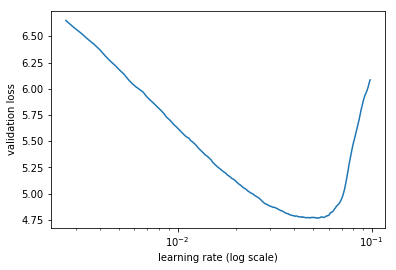

In [55]:
learner.sched.plot()

According to Fastai researchers optimal LR is a biggest value where loss is still significantly decreasing

In [56]:
lr=1e-2
lrs = lr
learner.fit(lrs, 1, wds=wd, cycle_len=50, use_clr_beta=(20,20,0.95,0.85))

epoch      trn_loss   val_loss   accuracy                   
    0      4.758472   4.527741   0.313736  
    1      4.376474   4.225862   0.338205                   
    2      4.14226    4.064678   0.351058                   
    3      3.971739   3.97463    0.359257                   
    4      3.840452   3.924864   0.365203                   
    5      3.741312   3.896128   0.367376                   
    6      3.654197   3.899738   0.367836                   
    7      3.593265   3.890822   0.36992                    
    8      3.543114   3.899772   0.368917                   
    9      3.522797   3.904227   0.368674                   
    10     3.481125   3.924049   0.368174                   
    11     3.520878   3.885577   0.369876                   
    12     3.458382   3.931189   0.369122                   
    13     3.459353   3.944563   0.367884                   
    14     3.472638   3.941541   0.366836                   
    15     3.469951   3.956757   0.367238

[array([4.11784]), 0.3754734806716442]

In [57]:
learner.save('lmorg_bwd')
learner.save_encoder('lmorg_enc_bwd')

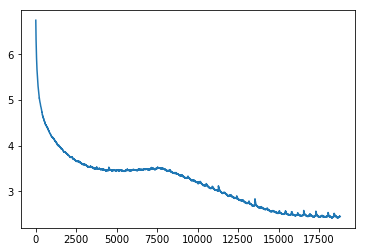

In [58]:
learner.sched.plot_loss()

### Forward - wikitext103 conversion

In [59]:
em_sz,nh,nl = 400,1150,3

In [60]:
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [61]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

#let's remove items from wikitext which are not used in twitter data # save the memory
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

Now overwrite the weights into the wgts odict.
The decoder module is also loaded with the same weights due to an idea called weight tying.

In [62]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

### Forward - Language model

In [63]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [64]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [65]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15]) * 1.

First tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So
freeze everything except the last layer.

In [66]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [67]:
learner.model.load_state_dict(wgts)

In [68]:
lr=1e-3
lrs = lr

In [69]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      5.618321   5.22793    0.256074  



[array([5.22793]), 0.2560740280896425]

In [70]:
learner.unfreeze()

In [71]:
learner.lr_find(wds = wd, start_lr=lrs/100, end_lr=lrs*100, linear=True)

epoch      trn_loss   val_loss   accuracy                   
    0      7.615104   7.753351   0.115321  



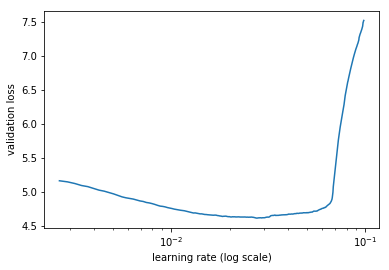

In [72]:
learner.sched.plot()

In [73]:
lr=1e-2
lrs = lr
learner.fit(lrs, 1, wds=wd, cycle_len=50, use_clr_beta=(20,20,0.95,0.85))

epoch      trn_loss   val_loss   accuracy                   
    0      4.282513   4.030197   0.358103  
    1      4.014571   3.880066   0.369922                   
    2      3.839887   3.807143   0.375872                   
    3      3.695459   3.773499   0.378392                   
    4      3.634002   3.757751   0.379198                   
    5      3.551398   3.775701   0.378423                   
    6      3.498381   3.801439   0.376975                   
    7      3.489707   3.821314   0.375121                   
    8      3.456516   3.820474   0.375959                   
    9      3.455081   3.842313   0.376047                   
    10     3.457357   3.852042   0.3761                     
    11     3.480555   3.868874   0.374708                   
    12     3.499701   3.88024    0.372922                   
    13     3.512118   3.892895   0.370704                   
    14     3.541986   3.894297   0.370237                   
    15     3.561718   3.894807   0.370381

[array([4.01957]), 0.37952770441770556]

In [74]:
learner.save('lmorg')
learner.save_encoder('lmorg_enc')

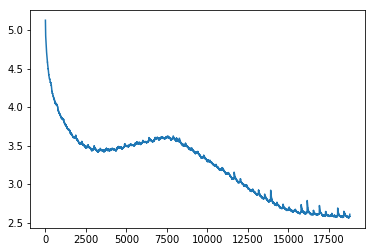

In [75]:
learner.sched.plot_loss()

## Classifier tokens

The classifier model is basically a linear layer custom head on top of the LM backbone. 
Let's first load the tokens for the model

In [24]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [25]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
0


In [26]:
len(tok_trn)

32085

In [27]:

(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [28]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [29]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(stoi)

22471

In [30]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [31]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

## Classifier

In [32]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [33]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [34]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 256

In [35]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [36]:
lengths = np.vectorize(len)(trn_clas)

In [37]:
len(np.where(lengths>70)[0])

2

In the classifier, unlike LM, we need to read a twit at a time and learn to predict the it's sentiment as pos/neg. We do not deal with equal bptt size batches, so we have to pad the sequences to the same length in each batch. To not pad too much, we use a sortish sampler method invented by [@Smerity](https://twitter.com/Smerity) and [@jekbradbury](https://twitter.com/jekbradbury). Good things in a twitter data is that only few obs have more than 70 tokens (bptt parameter).


Modify the loader class to produce input for both forward and backward models

In [104]:
class BiDirDataLoader(DataLoader):
    def __init__(self, dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, pad_idx=0,
                 num_workers=None, pin_memory=False, drop_last=False, pre_pad=True, half=False,
                 transpose=False, transpose_y=False):
        super().__init__(dataset, batch_size, shuffle, sampler, batch_sampler, pad_idx,
                 num_workers, pin_memory, drop_last, pre_pad, half,
                 transpose, transpose_y)

    def jag_stack(self, b):
        if len(b[0].shape) not in (1,2): return np.stack(b)
        ml = max(len(o) for o in b)
        if min(len(o) for o in b)==ml: return np.stack(b)
        res = np.zeros((len(b), ml), dtype=b[0].dtype) + self.pad_idx
        res_bwd = np.zeros((len(b), ml), dtype=b[0].dtype) + self.pad_idx
        for i,o in enumerate(b):
            res[i, -len(o):] = o
            res_bwd[i, -len(o):] = o[::-1]
        return np.concatenate([res,res_bwd], axis=1)

In [105]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = BiDirDataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = BiDirDataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [229]:
dps = np.array([0.4,0.5,0.05,0.3,0.4]) * 1.1 #*0.5

In [250]:
#modify this fastai class to ouput also hidden state
class RNN_Encoder(nn.Module):

    """A custom RNN encoder network that uses
        - an embedding matrix to encode input,
        - a stack of LSTM or QRNN layers to drive the network, and
        - variational dropouts in the embedding and LSTM/QRNN layers

        The architecture for this network was inspired by the work done in
        "Regularizing and Optimizing LSTM Language Models".
        (https://arxiv.org/pdf/1708.02182.pdf)
    """

    initrange=0.1

    def __init__(self, ntoken, emb_sz, nhid, nlayers, pad_token, bidir=False,
                 dropouth=0.3, dropouti=0.65, dropoute=0.1, wdrop=0.5, qrnn=False, bias=False):
        """ Default constructor for the RNN_Encoder class

            Args:
                bs (int): batch size of input data
                ntoken (int): number of vocabulary (or tokens) in the source dataset
                emb_sz (int): the embedding size to use to encode each token
                nhid (int): number of hidden activation per LSTM layer
                nlayers (int): number of LSTM layers to use in the architecture
                pad_token (int): the int value used for padding text.
                dropouth (float): dropout to apply to the activations going from one LSTM layer to another
                dropouti (float): dropout to apply to the input layer.
                dropoute (float): dropout to apply to the embedding layer.
                wdrop (float): dropout used for a LSTM's internal (or hidden) recurrent weights.

            Returns:
                None
          """

        super().__init__()
        self.ndir = 2 if bidir else 1
        self.bs, self.qrnn = 1, qrnn
        self.encoder = nn.Embedding(ntoken, emb_sz, padding_idx=pad_token)
        self.encoder_with_dropout = EmbeddingDropout(self.encoder)
        if self.qrnn:
            #Using QRNN requires cupy: https://github.com/cupy/cupy
            from .torchqrnn.qrnn import QRNNLayer
            self.rnns = [QRNNLayer(emb_sz if l == 0 else nhid, (nhid if l != nlayers - 1 else emb_sz)//self.ndir,
                save_prev_x=True, zoneout=0, window=2 if l == 0 else 1, output_gate=True) for l in range(nlayers)]
            if wdrop:
                for rnn in self.rnns:
                    rnn.linear = WeightDrop(rnn.linear, wdrop, weights=['weight'])
        else:
            self.rnns = [nn.LSTM(emb_sz if l == 0 else nhid, (nhid if l != nlayers - 1 else emb_sz)//self.ndir,
                1, bidirectional=bidir) for l in range(nlayers)]
            if wdrop: self.rnns = [WeightDrop(rnn, wdrop) for rnn in self.rnns]
        self.rnns = torch.nn.ModuleList(self.rnns)
        self.encoder.weight.data.uniform_(-self.initrange, self.initrange)

        self.emb_sz,self.nhid,self.nlayers,self.dropoute = emb_sz,nhid,nlayers,dropoute
        self.dropouti = LockedDropout(dropouti)
        self.dropouths = nn.ModuleList([LockedDropout(dropouth) for l in range(nlayers)])

    def forward(self, input):
        """ Invoked during the forward propagation of the RNN_Encoder module.
        Args:
            input (Tensor): input of shape (sentence length x batch_size)

        Returns:
            raw_outputs (tuple(list (Tensor), list(Tensor)): list of tensors evaluated from each RNN layer without using
            dropouth, list of tensors evaluated from each RNN layer using dropouth,
        """
        sl,bs = input.size()
        if bs!=self.bs:
            self.bs=bs
            self.reset()
        with set_grad_enabled(self.training):
            emb = self.encoder_with_dropout(input, dropout=self.dropoute if self.training else 0)
            emb = self.dropouti(emb)
            raw_output = emb
            new_hidden,raw_outputs,outputs = [],[],[]
            for l, (rnn,drop) in enumerate(zip(self.rnns, self.dropouths)):
                current_input = raw_output
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    raw_output, new_h = rnn(raw_output, self.hidden[l])
                new_hidden.append(new_h)
                raw_outputs.append(raw_output)
                if l != self.nlayers - 1: raw_output = drop(raw_output)
                outputs.append(raw_output)
            self.hidden = repackage_var(new_hidden)
        return raw_outputs, outputs, new_hidden

    def one_hidden(self, l):
        nh = (self.nhid if l != self.nlayers - 1 else self.emb_sz)//self.ndir
        if IS_TORCH_04: return Variable(self.weights.new(self.ndir, self.bs, nh).zero_())
        else: return Variable(self.weights.new(self.ndir, self.bs, nh).zero_(), volatile=not self.training)

    def reset(self):
        if self.qrnn: [r.reset() for r in self.rnns]
        self.weights = next(self.parameters()).data
        if self.qrnn: self.hidden = [self.one_hidden(l) for l in range(self.nlayers)]
        else: self.hidden = [(self.one_hidden(l), self.one_hidden(l)) for l in range(self.nlayers)]
            
#modify this fastai class to ouput also hidden state           
class MultiBatchRNN(RNN_Encoder):
    def __init__(self, bptt, max_seq, *args, **kwargs):
        self.max_seq,self.bptt = max_seq,bptt
        super().__init__(*args, **kwargs)

    def concat(self, arrs):
        return [torch.cat([l[si] for l in arrs]) for si in range(len(arrs[0]))]

    def forward(self, input):
        sl,bs = input.size()
        for l in self.hidden:
            for h in l: h.data.zero_()
        raw_outputs, outputs = [],[]
        for i in range(0, sl, self.bptt):
            r, o, h = super().forward(input[i: min(i+self.bptt, sl)])
            if i>(sl-self.max_seq):
                raw_outputs.append(r)
                outputs.append(o)
        return self.concat(raw_outputs), self.concat(outputs), h

#create a class which will take as an input two rnns and on top of that will create classifier
class BiDir_Classifier(nn.Module):
    def __init__(self, bptt, max_seq, n_class, n_tok, emb_sz, n_hid, n_layers, pad_token, layers, drops, bidir=False,
                      dropouth=0.3, dropouti=0.5, dropoute=0.1, wdrop=0.5, qrnn=False):
        super().__init__()
        self.rnn1 = MultiBatchRNN(bptt, max_seq, n_tok, emb_sz, n_hid, n_layers, pad_token=pad_token, bidir=bidir,
                      dropouth=dropouth, dropouti=dropouti, dropoute=dropoute, wdrop=wdrop, qrnn=qrnn)
        self.rnn2 = MultiBatchRNN(bptt, max_seq, n_tok, emb_sz, n_hid, n_layers, pad_token=pad_token, bidir=bidir,
                       dropouth=dropouth, dropouti=dropouti, dropoute=dropoute, wdrop=wdrop, qrnn=qrnn)
        self.layers = nn.ModuleList([
            LinearBlock(layers[i], layers[i + 1], drops[i]) for i in range(len(layers) - 1)])
        self.rnn1.reset()
        self.rnn2.reset()
        

    def pool(self, x, bs, is_max):
        f = F.adaptive_max_pool1d if is_max else F.adaptive_avg_pool1d
        return f(x.permute(1,2,0), (1,)).view(bs,-1)
    
    def forward(self, input):
        l_, _ = input.shape
        half_l = l_//2
        
        r1 = self.rnn1(input[:half_l])
        r2 = self.rnn2(input[half_l:])
        raw_outputs1, outputs1, hiddens1 = r1
        raw_outputs2, outputs2, hiddens2 = r2
        sl,bs,_ = outputs1[-1].size()
        cell1= hiddens1[-1][0].permute(1,2,0).view(bs,-1)
        #cell2= hiddens2[-1][0].permute(1,2,0).view(bs,-1)
        output1 = outputs1[-1]
        output2 = outputs2[-1]
        
        #avgpool1 = self.pool(output1, bs, False)
        #avgpool2 = self.pool(output2, bs, False)
        mxpool1 = self.pool(output1, bs, True)
        mxpool2 = self.pool(output2, bs, True)
        
        #input to the classifier
        x = torch.cat([cell1, mxpool1, mxpool2], 1)
        #x = torch.cat([cl], 1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return l_x, raw_outputs1, outputs1

class TextModel(BasicModel):
    def get_layer_groups(self):
        m = self.model
        return [(m.rnn1.encoder, m.rnn1.dropouti, m.rnn2.encoder, m.rnn2.dropouti), 
                *zip(m.rnn1.rnns, m.rnn1.dropouths, m.rnn2.rnns, m.rnn2.dropouths), (m.layers)]



In [251]:
m = BiDir_Classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [252]:
#Lets create a learner object
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=0.3

'''
from sklearn.metrics import f1_score, precision_score, recall_score
def f1pn(preds, targs):
    top_preds = torch.max(preds, dim=1)[1]
    return f1_score(targs, top_preds, average='macro',
                       labels=[0,2])

def recall_avg(preds, targs):
    top_preds = torch.max(preds, dim=1)[1]
    return recall_score(targs, top_preds, average='macro')
'''

metrics = [accuracy]
learn.metrics = metrics

In [253]:
#summary of the model
#print(m)
for name, param in learn.model.state_dict().items():
    print(name, param.shape)

rnn1.encoder.weight torch.Size([22471, 400])
rnn1.encoder_with_dropout.embed.weight torch.Size([22471, 400])
rnn1.rnns.0.module.weight_ih_l0 torch.Size([4600, 400])
rnn1.rnns.0.module.bias_ih_l0 torch.Size([4600])
rnn1.rnns.0.module.bias_hh_l0 torch.Size([4600])
rnn1.rnns.0.module.weight_hh_l0_raw torch.Size([4600, 1150])
rnn1.rnns.1.module.weight_ih_l0 torch.Size([4600, 1150])
rnn1.rnns.1.module.bias_ih_l0 torch.Size([4600])
rnn1.rnns.1.module.bias_hh_l0 torch.Size([4600])
rnn1.rnns.1.module.weight_hh_l0_raw torch.Size([4600, 1150])
rnn1.rnns.2.module.weight_ih_l0 torch.Size([1600, 1150])
rnn1.rnns.2.module.bias_ih_l0 torch.Size([1600])
rnn1.rnns.2.module.bias_hh_l0 torch.Size([1600])
rnn1.rnns.2.module.weight_hh_l0_raw torch.Size([1600, 400])
rnn2.encoder.weight torch.Size([22471, 400])
rnn2.encoder_with_dropout.embed.weight torch.Size([22471, 400])
rnn2.rnns.0.module.weight_ih_l0 torch.Size([4600, 400])
rnn2.rnns.0.module.bias_ih_l0 torch.Size([4600])
rnn2.rnns.0.module.bias_hh_l0 t

In [254]:
#Fastai practitioners suggest to use different lr for different part of the model
#lrs=np.array([5e-5,5e-5,2e-4,5e-4,1e-3])
lrs=np.array([2e-4,2e-4,1e-3,2e-3,5e-3]) 
#lrs=5e-3
wd = 1e-7

In [271]:
#layer groups can be found using following
#there is 5 layer groups in this model
list(enumerate(learn.get_layer_groups()))

[(0, (Embedding(22471, 400, padding_idx=1), LockedDropout(
   ), Embedding(22471, 400, padding_idx=1), LockedDropout(
   ))), (1, (WeightDrop(
     (module): LSTM(400, 1150)
   ), LockedDropout(
   ), WeightDrop(
     (module): LSTM(400, 1150)
   ), LockedDropout(
   ))), (2, (WeightDrop(
     (module): LSTM(1150, 1150)
   ), LockedDropout(
   ), WeightDrop(
     (module): LSTM(1150, 1150)
   ), LockedDropout(
   ))), (3, (WeightDrop(
     (module): LSTM(1150, 400)
   ), LockedDropout(
   ), WeightDrop(
     (module): LSTM(1150, 400)
   ), LockedDropout(
   ))), (4, ModuleList(
    (0): LinearBlock(
      (lin): Linear(in_features=1200, out_features=50, bias=True)
      (drop): Dropout(p=0.44000000000000006)
      (bn): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): LinearBlock(
      (lin): Linear(in_features=50, out_features=3, bias=True)
      (drop): Dropout(p=0.1)
      (bn): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True)
    )
  ))]

In [255]:
#load the pretrain weights to the encoders
wgts = torch.load(PATH/'models/lmorg_enc.h5', map_location=lambda storage, loc: storage)
wgts2 = torch.load(PATH/'models/lmorg_enc_bwd.h5', map_location=lambda storage, loc: storage)

learn.model.rnn1.load_state_dict(wgts)
learn.model.rnn2.load_state_dict(wgts2)

In [256]:
learn.freeze_to(-1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.988018   1.162609   0.376344  


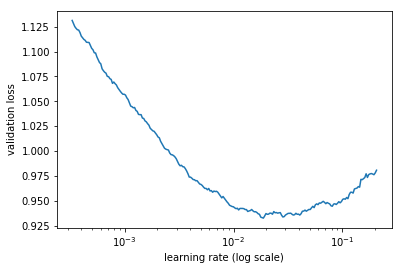

In [194]:
learn.lr_find(lrs/100, lrs*10)
learn.sched.plot()

lr=2e-3
lrm = 5.
lrs = np.array([lr/(lrm**2), lr/(lrm**2), lr/(lrm**2), lr/lrm, lr])
lrs

In [195]:
#lrs=np.array([1e-5,1e-5,5e-5,1e-4,5e-4])

In [196]:
learn.fit(lrs, 1, wds=wd, cycle_len=2, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                    
    0      0.903943   0.885328   0.550768  
    1      0.888106   0.869195   0.582044                    


[array([0.86919]), 0.5820444010908821]

In [197]:
#learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3)) #0.62

In [198]:
learn.save('clas_0')

In [199]:
learn.load('clas_0')

In [200]:
learn.freeze_to(-2)
learn.fit(lrs, 1, wds=wd, cycle_len=4, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                    
    0      0.850722   0.849863   0.593706  
    1      0.816337   0.821846   0.604733                    
    2      0.7818     0.8148     0.618834                    
    3      0.79627    0.780124   0.641278                    


[array([0.78012]), 0.641278360584475]

In [201]:
learn.freeze_to(-3)
learn.fit(lrs, 1, wds=wd, cycle_len=4, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                    
    0      0.784638   0.770602   0.637082  
    1      0.785558   0.793088   0.630446                    
    2      0.769756   0.781791   0.646304                    
    3      0.751688   0.759828   0.650305                    


[array([0.75983]), 0.6503049524303296]

In [202]:
#oryginal lm - 0.64

In [203]:
learn.save('clas_1')

In [204]:
learn.load('clas_1')

In [205]:
learn.unfreeze()

In [207]:
learn.fit(lrs, 1, wds=wd, cycle_len=8, use_clr_beta=(20,20,0.95,0.85))

epoch      trn_loss   val_loss   accuracy                    
    0      0.748245   0.773685   0.637814  
    1      0.753921   0.76915    0.642986                    
    2      0.812521   0.841472   0.604879                    
    3      0.770827   0.829907   0.618883                    
    4      0.761529   0.789977   0.637717                    
    5      0.752548   0.770926   0.641522                    
    6      0.731447   0.783925   0.639083                    
    7      0.738937   0.790165   0.639668                    


[array([0.79016]), 0.6396682117676904]

### Summary
Training earliest layers gave not that good results. The final model will be the one trained on 3 last layer groups which gave 65% of accuracy